<a href="https://colab.research.google.com/github/dkumar-22/Human-Activity-Recognition/blob/main/Human_Action_Recogntion_using_CNN_%2B_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **<center><font style="color:rgb(100,109,254)">Human Action Recognition in Videos using Keras (CNN,LSTM & LRCN)</font> </center>**


### **<font style="color:rgb(134,19,348)"> Import the Libraries</font>**

We will start by installing and importing the required libraries.

In [ ]:
# Discard the output of this cell.
%%capture

# Install the required libraries.
!pip install pytube
!pip install --upgrade youtube-dl
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

In [ ]:
# Import the required libraries.
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
import youtube_dl

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [ ]:
## Done to reduce the degree of randomness in the data and to make the data more less constant in all the runs that we will be doing

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

## **<font style="color:rgb(134,19,348)">Step 1: Download and Visualize the Data with its Labels</font>**

In the first step, we will download and visualize the data along with labels to get an idea about what we will be dealing with. We will be using the [UCF50 - Action Recognition Dataset](https://www.crcv.ucf.edu/data/UCF50.php), consisting of realistic videos taken from youtube which differentiates this data set from most of the other available action recognition data sets as they are not realistic and are staged by actors. The Dataset contains:

*   **`50`** Action Categories

*   **`25`** Groups of Videos per Action Category

*   **`133`** Average Videos per Action Category

*   **`199`** Average Number of Frames per Video

*   **`320`** Average Frames Width per Video

*   **`240`** Average Frames Height per Video

*   **`26`** Average Frames Per Seconds per Video

Let's download and extract the dataset.

In [ ]:
# Discard the output of this cell.
%%capture

# Downlaod the UCF50 Dataset
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar

#Extract the Dataset
!unrar x UCF50.rar

For visualization, we will pick a random categories from the dataset and a random video from each selected category and will visualize the first frame of the selected videos with their associated labels written also with the normalized frame

(-0.5, 63.5, 63.5, -0.5)

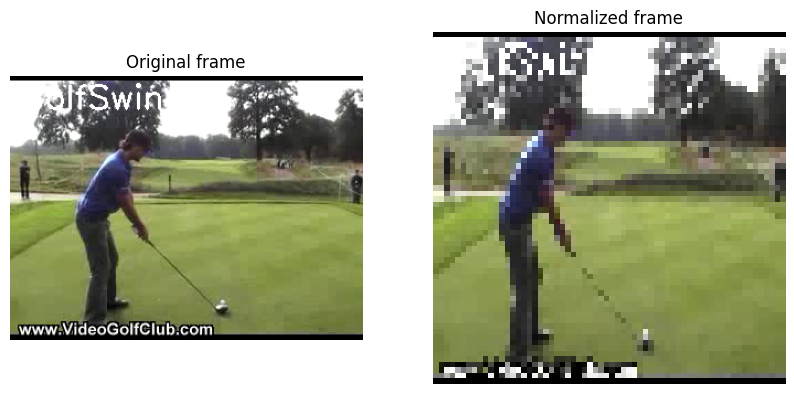

In [ ]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (10, 8))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('UCF50')

# Generate a list of 20 random values. The values will be between 0-50,
# where 50 is the total number of class in the dataset.
# random_index = random.choice(range(len(all_classes_names)))

# Retrieve a Class Name using the Random Index.
selected_class_Name = "GolfSwing"

# Retrieve the list of all the video files present in the randomly selected Class Directory.
video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')

# Randomly select a video file from the list retrieved from the randomly selected Class Directory.
selected_video_file_name = random.choice(video_files_names_list)

# Initialize a VideoCapture object to read from the video File.
video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')

# Read the first frame of the video file.
_, bgr_frame = video_reader.read()

# Release the VideoCapture object.
video_reader.release()

# Convert the frame from BGR into RGB format. Open CV default color scheme: BGR
rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

# Write the class name on the video frame.
cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Resize the Frame to fixed height and width.
resized_frame = cv2.resize(rgb_frame, (64,64))
# Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
normalized_frame = resized_frame / 255
cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

# Display the frame.
plt.subplot(1, 2, 1);plt.imshow(rgb_frame);plt.title("Original frame");plt.axis('off')
plt.subplot(1, 2, 2);plt.imshow(normalized_frame);plt.title("Normalized frame");plt.axis('off')

## **<font style="color:rgb(134,19,348)">Step 2: Preprocess the Dataset</font>**

Next, we will perform some preprocessing on the dataset. First, we will read the video files from the dataset and resize the frames of the videos to a fixed width and height, to reduce the computations and normalized the data to range `[0-1]` by dividing the pixel values with `255`, which makes convergence faster while training the network.

*But first, let's initialize some constants.*

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
# Since the LSTM works upon the sequential dataset
SEQUENCE_LENGTH = 20

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "UCF50"

# Specify the list containing the names of the classes used for training.
CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

**Note:** *The **`IMAGE_HEIGHT`**, **`IMAGE_WIDTH`** and **`SEQUENCE_LENGTH`** constants can be increased for better results, although increasing the sequence length is only effective to a certain point, and increasing the values will result in the process being more computationally expensive.*

### **<font style="color:rgb(134,19,348)">Create a Function to Extract, Resize & Normalize Frames</font>**

We will create a function **`frames_extraction()`** that will create a list containing the resized and normalized frames of a video whose path is passed to it as an argument. The function will read the video file frame by frame, although not all frames are added to the list as we will only need an evenly distributed sequence length of frames.

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

### **<font style="color:rgb(134,19,348)">Create a Function for Dataset Creation</font>**

Now we will create a function **`create_dataset()`** that will iterate through all the classes specified in the **`CLASSES_LIST`** constant and will call the function  **`frame_extraction()`** on every video file of the selected classes and return the frames (**`features`**), class index ( **`labels`**), and video file path (**`video_files_paths`**).

In [ ]:
def create_dataset():
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        # Iterate through all the files present in the files list.
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

Now we will utilize the function **`create_dataset()`** created above to extract the data of the selected classes and create the required dataset.

In [ ]:
# Create the dataset.
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


Now we will convert `labels` (class indexes) into one-hot encoded vectors.

In [ ]:
# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)

## **<font style="color:rgb(134,19,348)">Step 3: Split the Data into Train and Test Set</font>**

As of now, we have the required **`features`** (a NumPy array containing all the extracted frames of the videos) and **`one_hot_encoded_labels`** (also a Numpy array containing all class labels in one hot encoded format). So now, we will split our data to create training and testing sets. We will also shuffle the dataset before the split to avoid any bias and get splits representing the overall distribution of the data.

In [ ]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels,
                                                                            test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

## **<font style="color:rgb(134,19,348)">Implementing the LRCN Approach</font>**

In this step, we will implement another approach known as the Long-term Recurrent Convolutional Network (LRCN), which combines CNN and LSTM layers in a single model. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to LSTM layer(s) at each time-steps for temporal sequence modeling. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://drive.google.com/uc?export=download&id=1I-q5yLsIoNh2chfzT7JYvra17FsXvdme'>
</center>

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Construct the Model</font>**

To implement our LRCN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`LSTM`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`LSTM`** layer to predict the action being performed.

In [ ]:
def create_LRCN_model():
    '''
    This function will construct the required LRCN model.
    Returns:
        model: It is the required constructed LRCN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    #model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(LSTM(32))

    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed LRCN model.
    return model

Now we will utilize the function **`create_LRCN_model()`** created above to construct the required `LRCN` model.

In [ ]:
# Construct the required LRCN model.
LRCN_model = create_LRCN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 20, 64, 64, 16)    448       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 20, 16, 16, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 20, 16, 16, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 20, 4, 4, 32)      0

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LRCN` model. As we had checked for the previous model.

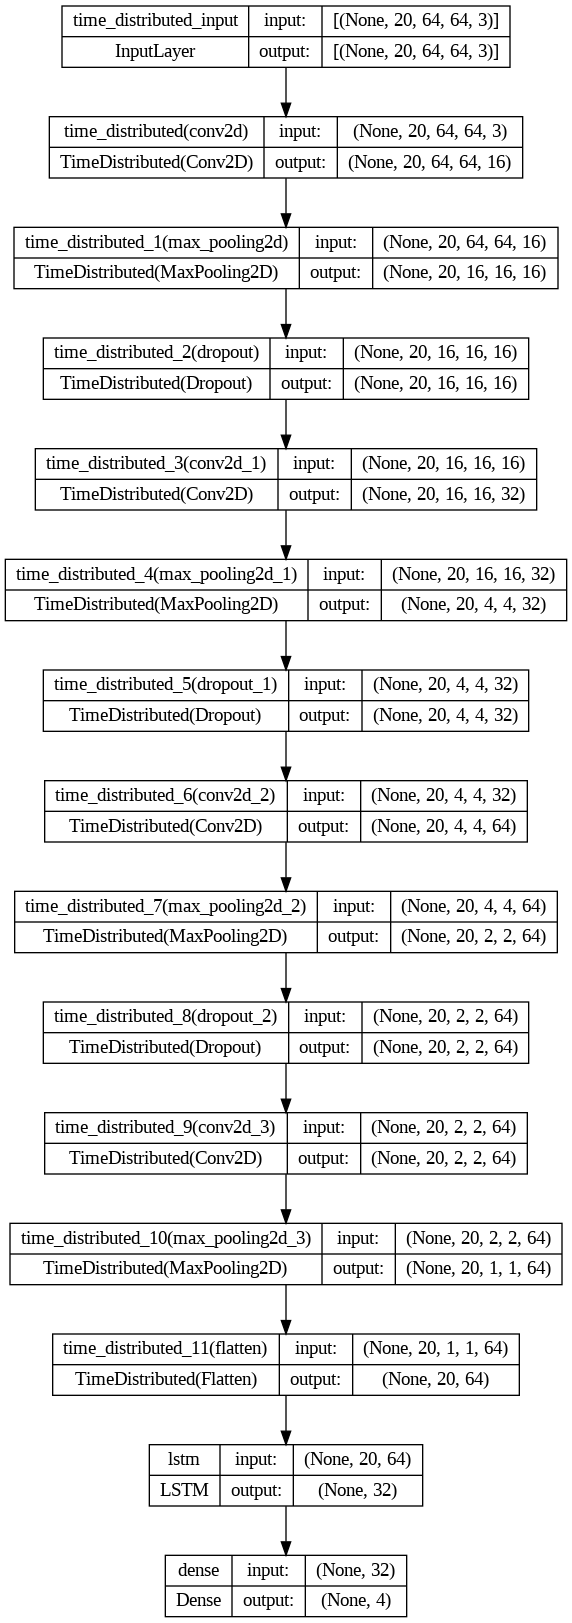

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 10, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/10
69/69 [==============================] - 19s 206ms/step - loss: 0.1555 - accuracy: 0.9487 - val_loss: 0.4328 - val_accuracy: 0.8804
Epoch 2/10
69/69 [==============================] - 14s 198ms/step - loss: 0.0305 - accuracy: 0.9853 - val_loss: 0.2778 - val_accuracy: 0.9239
Epoch 3/10
69/69 [==============================] - 13s 190ms/step - loss: 0.0391 - accuracy: 0.9853 - val_loss: 0.4170 - val_accuracy: 0.9130
Epoch 4/10
69/69 [==============================] - 13s 189ms/step - loss: 0.1744 - accuracy: 0.9487 - val_loss: 0.3289 - val_accuracy: 0.8913
Epoch 5/10
69/69 [==============================] - 13s 191ms/step - loss: 0.0632 - accuracy: 0.9817 - val_loss: 0.4471 - val_accuracy: 0.8587
Epoch 6/10
69/69 [==============================] - 14s 210ms/step - loss: 0.1138 - accuracy: 0.9634 - val_loss: 0.2947 - val_accuracy: 0.9022
Epoch 7/10
69/69 [==============================] - 14s 207ms/step - loss: 0.0171 - accuracy: 0.9927 - val_loss: 0.1546 - val_accuracy: 0.9457

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `LRCN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 3s 460ms/step - loss: 0.3416 - accuracy: 0.9180


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
LRCN_model.save(model_file_name)

  saving_api.save_model(



In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**


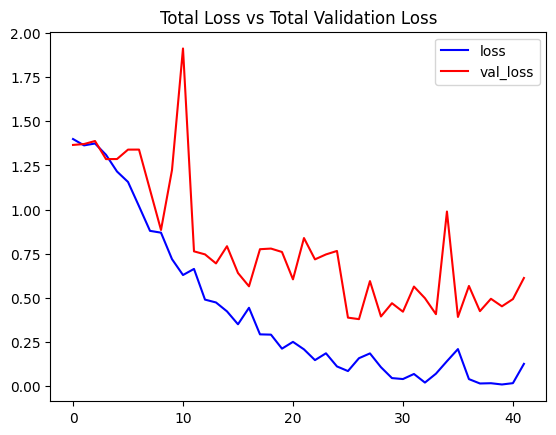

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

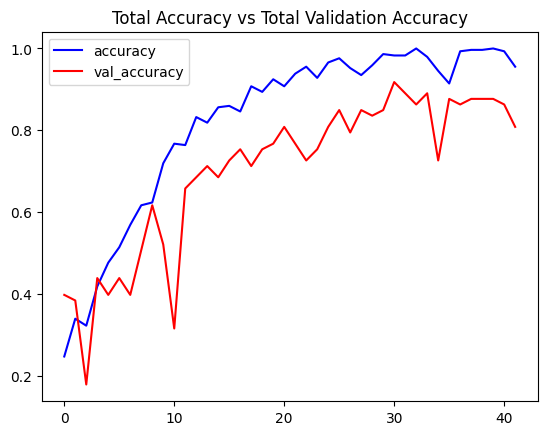

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Plot Confusion Matrix**

In [ ]:
label_pred_val = LRCN_model.predict(features_test)

# Convert predicted probabilities to class labels
labels_test_single = np.argmax(labels_test, axis=1)
labels_pred = np.argmax(label_pred_val, axis=1)

4/4 [==============================] - 0s 22ms/step



Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.71      0.74        24
           1       0.92      0.85      0.88        27
           2       0.89      0.94      0.91        33
           3       0.93      0.97      0.95        38

    accuracy                           0.89       122
   macro avg       0.88      0.87      0.87       122
weighted avg       0.88      0.89      0.88       122



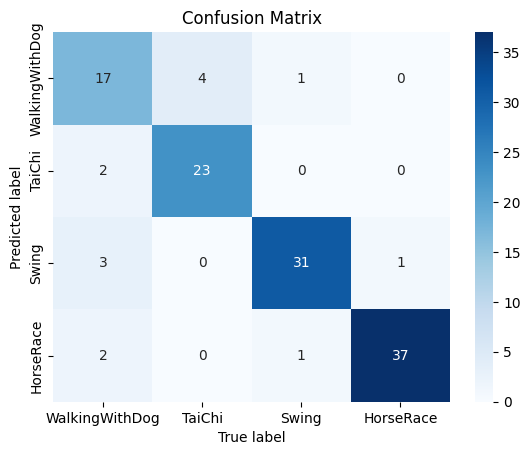

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(labels_test_single, labels_pred)
classification_rep = classification_report(labels_test_single, labels_pred)
print(f'\nClassification Report:\n{classification_rep}')
# Visualize confusion matrix
sns.heatmap(cm.T, annot=True, cmap='Blues', fmt='d', xticklabels=["WalkingWithDog", "TaiChi", "Swing", "HorseRace"], yticklabels=[ "WalkingWithDog", "TaiChi", "Swing", "HorseRace"])
plt.title('Confusion Matrix')
plt.xlabel('True label')
plt.ylabel('Predicted label')
thresh = cm.max() / 2.  # threshold for coloring text
plt.show()

## **<font style="color:rgb(134,19,348)">Implementing the CNN Approach</font>**

In this step, we will implement CNN(Convolution Neural Network) approach. The Convolutional layers are used for spatial feature extraction from the frames, and the extracted spatial features are fed to 1D Convolution layert. We are using 1D convolutional layers or fully connected layers to capture temporal dependencies across the sequence of flattened features.  This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.

<center>
<img src='https://miro.medium.com/v2/resize:fit:1400/1*7_BCJFzekmPXmJQVRdDgwg.png'>
</center>

We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Construct the Model</font>**

To implement our CNN architecture, we will use time-distributed **`Conv2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`Conv2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to a **`Conv1D`** layer and the **`fully connected`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`Conv1D`** layer to predict the action being performed.

In [ ]:
def create_CNN_model():
    '''
    This function will construct the required CNN model.
    Returns:
        model: It is the required constructed CNN model.
    '''

    # We will use a Sequential model for model construction.
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    # model.add(TimeDistributed(Dropout(0.25)))

    model.add(TimeDistributed(Flatten()))

    model.add(TimeDistributed(Dense(32, activation='relu')))  # Reduce the size of the Flatten layer to 32
    model.add(GlobalAveragePooling1D())
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    ########################################################################################################################

    # Display the model's summary.
    model.summary()

    # Return the constructed LRCN model without LSTM.
    return model

Now we will utilize the function **`create_CNN_model()`** created above to construct the required `CNN` model.

In [ ]:
# Construct the required LRCN model.
CNN_model = create_CNN_model()

# Display the success message.
print("Model Created Successfully!")

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_29 (TimeD  (None, 20, 64, 64, 16)    448       
 istributed)                                                     
                                                                 
 time_distributed_30 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_31 (TimeD  (None, 20, 16, 16, 16)    0         
 istributed)                                                     
                                                                 
 time_distributed_32 (TimeD  (None, 20, 16, 16, 32)    4640      
 istributed)                                                     
                                                                 
 time_distributed_33 (TimeD  (None, 20, 4, 4, 32)     

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `CNN` model. As we had checked for the previous model.

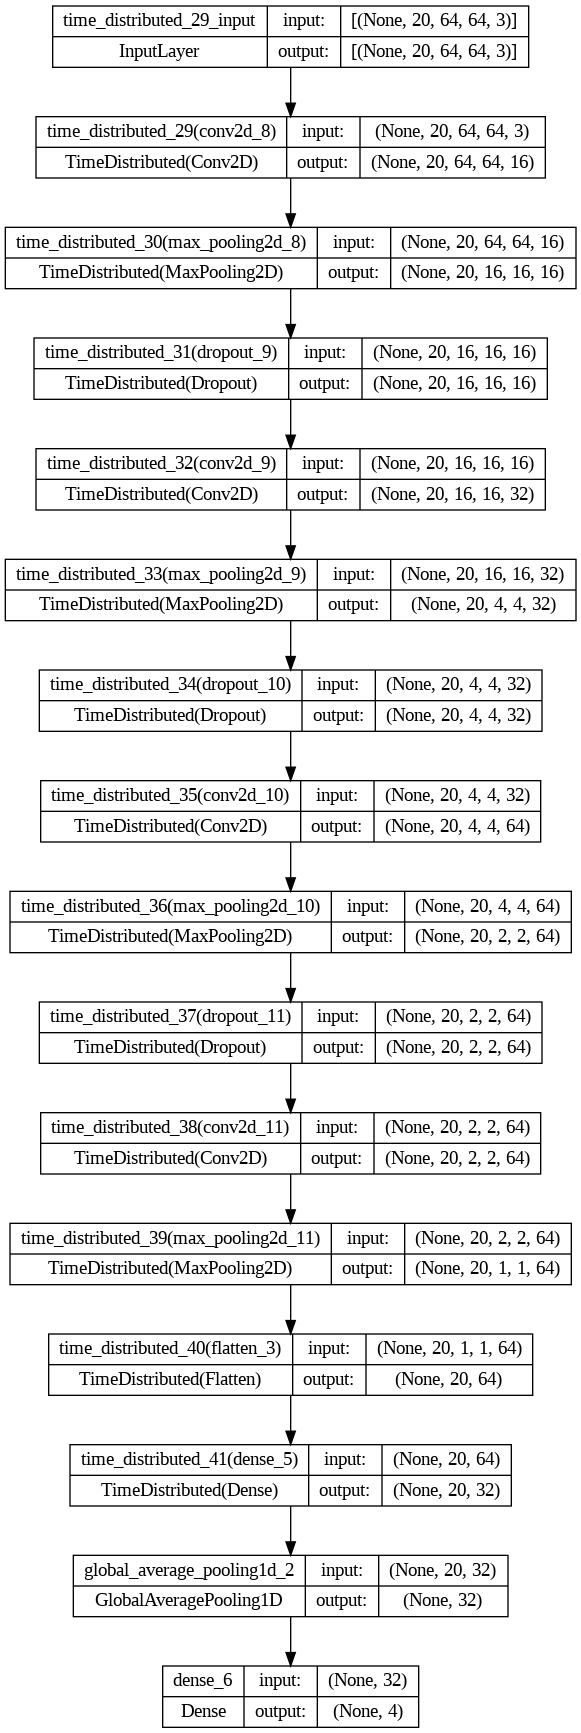

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model(CNN_model, to_file = 'CNN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

### **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
CNN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
CNN_model_training_history = CNN_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4 ,
                                             shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])

Epoch 1/30
69/69 [==============================] - 15s 185ms/step - loss: 1.3889 - accuracy: 0.2234 - val_loss: 1.3785 - val_accuracy: 0.4348
Epoch 2/30
69/69 [==============================] - 13s 187ms/step - loss: 1.3678 - accuracy: 0.2857 - val_loss: 1.3501 - val_accuracy: 0.4565
Epoch 3/30
69/69 [==============================] - 13s 190ms/step - loss: 1.2786 - accuracy: 0.4249 - val_loss: 1.2154 - val_accuracy: 0.4891
Epoch 4/30
69/69 [==============================] - 13s 188ms/step - loss: 1.1744 - accuracy: 0.4725 - val_loss: 1.1711 - val_accuracy: 0.5326
Epoch 5/30
69/69 [==============================] - 13s 185ms/step - loss: 0.9751 - accuracy: 0.6227 - val_loss: 1.0792 - val_accuracy: 0.5000
Epoch 6/30
69/69 [==============================] - 15s 226ms/step - loss: 0.8160 - accuracy: 0.6520 - val_loss: 0.9260 - val_accuracy: 0.5761
Epoch 7/30
69/69 [==============================] - 13s 185ms/step - loss: 0.7251 - accuracy: 0.7179 - val_loss: 0.8948 - val_accuracy: 0.6196

#### **<font style="color:rgb(134,19,348)">Evaluating the trained Model</font>**

As done for the previous one, we will evaluate the `CNN` model on the test set.

In [ ]:
# Evaluate the trained model.
model_evaluation_history = CNN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 2s 430ms/step - loss: 0.3361 - accuracy: 0.8689


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
CNN_model.save(model_file_name)

  saving_api.save_model(



In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**


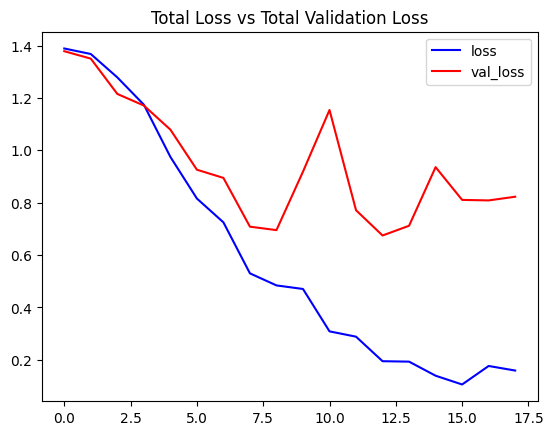

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(CNN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

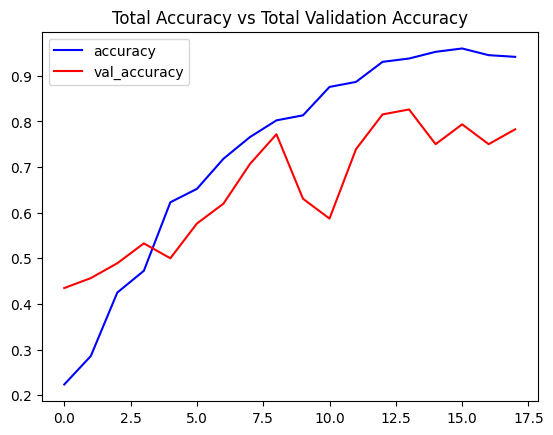

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(CNN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Plot Confusion Matrix**

In [ ]:
label_pred_val = CNN_model.predict(features_test)

# Convert predicted probabilities to class labels
labels_test_single = np.argmax(labels_test, axis=1)
labels_pred = np.argmax(label_pred_val, axis=1)

4/4 [==============================] - 3s 661ms/step



Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77        24
           1       0.89      0.89      0.89        27
           2       0.94      0.91      0.92        33
           3       0.88      1.00      0.94        38

    accuracy                           0.89       122
   macro avg       0.89      0.88      0.88       122
weighted avg       0.89      0.89      0.89       122



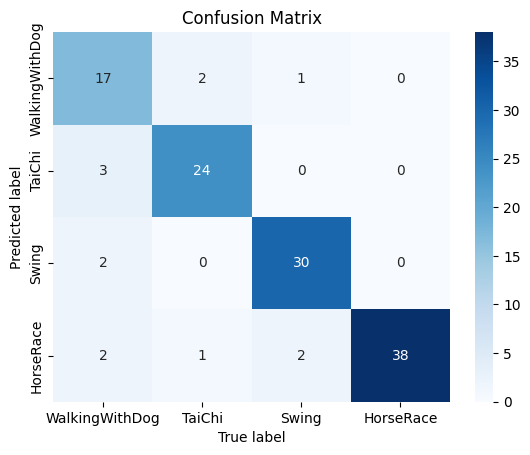

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(labels_test_single, labels_pred)
classification_rep = classification_report(labels_test_single, labels_pred)
print(f'\nClassification Report:\n{classification_rep}')
# Visualize confusion matrix
sns.heatmap(cm.T, annot=True, cmap='Blues', fmt='d', xticklabels=["WalkingWithDog", "TaiChi", "Swing", "HorseRace"], yticklabels=[ "WalkingWithDog", "TaiChi", "Swing", "HorseRace"])
plt.title('Confusion Matrix')
plt.xlabel('True label')
plt.ylabel('Predicted label')
thresh = cm.max() / 2.  # threshold for coloring text
plt.show()

## **<font style="color:rgb(134,19,348)">Implementing the LSTM Approach</font>**

In this step, we will implement ConvLSTM(Convolution Long Short Term Memory) approach. It's a LSTM with built-in Convolution. So it can detect spatoal aspecct in the data while also taking the temporal relationship into consideration. This way the network learns spatiotemporal features directly in an end-to-end training, resulting in a robust model.


We will also use [**`TimeDistributed`**](https://keras.io/api/layers/recurrent_layers/time_distributed/) wrapper layer, which allows applying the same layer to every frame of the video independently. So it makes a layer (around which it is wrapped) capable of taking input of shape `(no_of_frames, width, height, num_of_channels)` if originally the layer's input shape was `(width, height, num_of_channels)` which is very beneficial as it allows to input the whole video into the model in a single shot.

<center>
<img src='https://drive.google.com/uc?export=download&id=1CbauSm5XTY7ypHYBHH7rDSnJ5LO9CUWX' width=400>
</center>

### **<font style="color:rgb(134,19,348)">Construct the Model</font>**

To implement our LSTM architecture, we will use time-distributed **`ConvLSTM2D`** layers which will be followed by **`MaxPooling2D`** and **`Dropout`** layers. The feature extracted from the **`ConvLSTM2D`** layers will be then flattened using the  **`Flatten`** layer and will be fed to the **`fully connected`** layer. The **`Dense`** layer with softmax activation will then use the output from the **`Flatten`** layer to predict the action being performed.

In [ ]:
def create_convlstm_model():

  # We will use a Sequential model for model construction
    model = Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))

    model.add(ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    model.summary()

    return model

In [ ]:
convlstm_model = create_convlstm_model()

print("Model Created Successfully!")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed_13 (TimeD  (None, 20, 31, 31, 4)     0         
 istributed)                                                     
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                      

#### **<font style="color:rgb(134,19,348)">Check Model’s Structure:</font>**

Now we will use the **`plot_model()`** function to check the structure of the constructed `LSTM` model. As we had checked for the previous model.

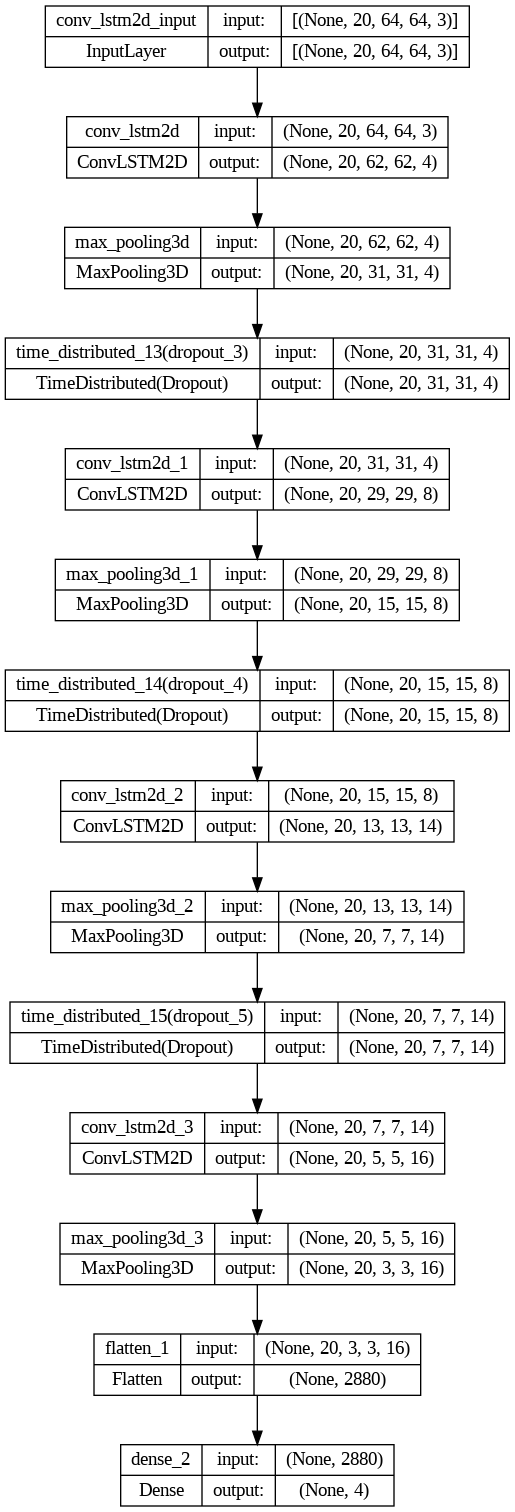

In [ ]:
# Plot the structure of the contructed LRCN model.
plot_model( convlstm_model, to_file = 'LSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 5, mode = 'min', restore_best_weights = True)

convlstm_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x = features_train, y = labels_train, epochs = 30, batch_size = 4,
                                                     shuffle = True, validation_split = 0.25,
                                                     callbacks = [early_stopping_callback])


Epoch 1/30
69/69 [==============================] - 119s 2s/step - loss: 1.3343 - accuracy: 0.3223 - val_loss: 1.2378 - val_accuracy: 0.4565
Epoch 2/30
69/69 [==============================] - 108s 2s/step - loss: 1.1952 - accuracy: 0.4872 - val_loss: 1.0392 - val_accuracy: 0.5652
Epoch 3/30
69/69 [==============================] - 108s 2s/step - loss: 0.9538 - accuracy: 0.6410 - val_loss: 1.0816 - val_accuracy: 0.5870
Epoch 4/30
69/69 [==============================] - 107s 2s/step - loss: 0.7689 - accuracy: 0.6813 - val_loss: 0.6810 - val_accuracy: 0.7283
Epoch 5/30
69/69 [==============================] - 107s 2s/step - loss: 0.5949 - accuracy: 0.7473 - val_loss: 0.7158 - val_accuracy: 0.7174
Epoch 6/30
69/69 [==============================] - 106s 2s/step - loss: 0.4613 - accuracy: 0.8132 - val_loss: 0.9168 - val_accuracy: 0.6739
Epoch 7/30
69/69 [==============================] - 107s 2s/step - loss: 0.3910 - accuracy: 0.8498 - val_loss: 0.7404 - val_accuracy: 0.7500
Epoch 8/30
69

### **<font style="color:rgb(134,19,348)">Compile & Train the Model</font>**


After checking the structure, we will compile and start training the model.

#### **<font style="color:rgb(134,19,348)">Evaluate the Trained Model</font>**

After training, we will evaluate the model on the test set.

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 [==============================] - 12s 3s/step - loss: 0.5907 - accuracy: 0.7623


#### **<font style="color:rgb(134,19,348)">Save the Model</font>**

After that, we will save the model for future uses using the same technique we had used for the previous model.

In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save the Model.
convlstm_model.save(model_file_name)

  saving_api.save_model(



In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

### **<font style="color:rgb(134,19,348)">Plot Model’s Loss & Accuracy Curves</font>**


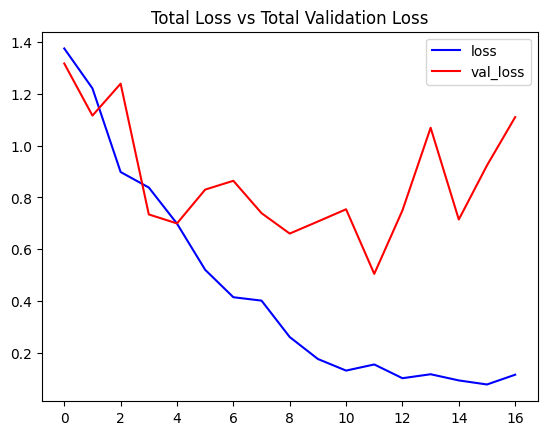

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

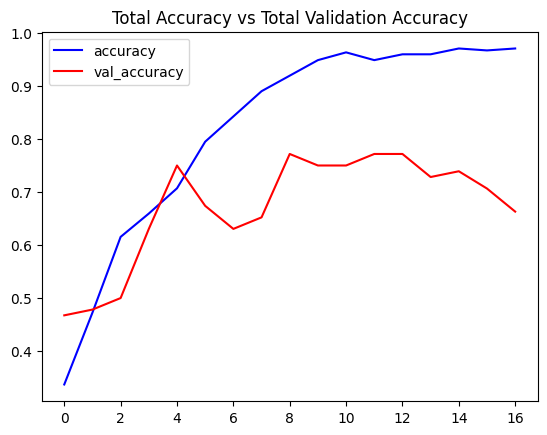

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

### **<font style="color:rgb(134,19,348)">Plot Confusion Matrix**

In [ ]:
label_pred_val = convlstm_model.predict(features_test)

# Convert predicted probabilities to class labels
labels_test_single = np.argmax(labels_test, axis=1)
labels_pred = np.argmax(label_pred_val, axis=1)

4/4 [==============================] - 14s 3s/step



Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        24
           1       0.83      0.74      0.78        27
           2       0.73      0.73      0.73        33
           3       0.87      0.89      0.88        38

    accuracy                           0.76       122
   macro avg       0.75      0.75      0.75       122
weighted avg       0.77      0.76      0.76       122



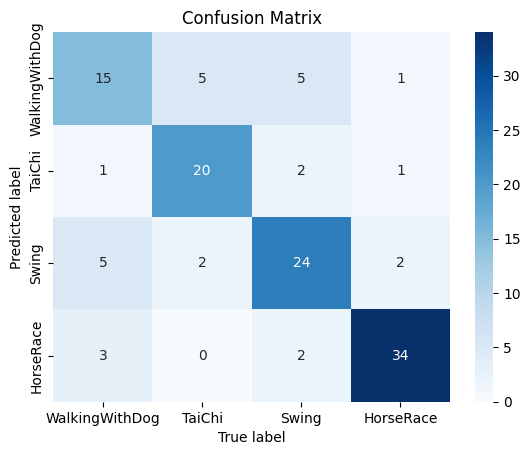

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(labels_test_single, labels_pred)
classification_rep = classification_report(labels_test_single, labels_pred)
print(f'\nClassification Report:\n{classification_rep}')
# Visualize confusion matrix
sns.heatmap(cm.T, annot=True, cmap='Blues', fmt='d', xticklabels=["WalkingWithDog", "TaiChi", "Swing", "HorseRace"], yticklabels=[ "WalkingWithDog", "TaiChi", "Swing", "HorseRace"])
plt.title('Confusion Matrix')
plt.xlabel('True label')
plt.ylabel('Predicted label')
thresh = cm.max() / 2.  # threshold for coloring text
plt.show()